In [1]:
import os
import re
import pathlib
from glob import glob

import earthaccess
import xrspatial
import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rxrmerge

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%store -r comanche_gdf pawnee_gdf c_soil_url_list p_soil_url_list

In [3]:
# build project and elevation directories

data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data'
)
project_dir = os.path.join(data_dir, 'habitat_suitability')
elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [4]:
# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [5]:
# search for the appropriate DEM

datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [7]:
# Define a pattern to identify DEM tiles associated with Comanche National Grassland.
srtm_c_pattern = os.path.join(elevation_dir, 'N36*hgt.zip')
if not glob(srtm_c_pattern):
    bounds = tuple(comanche_gdf.total_bounds)
    srtm_c_results = earthaccess.search_data(
        short_name = "SRTMGL1",
        bounding_box=bounds    
    )
    srtm_c_results = earthaccess.download(srtm_c_results, elevation_dir)

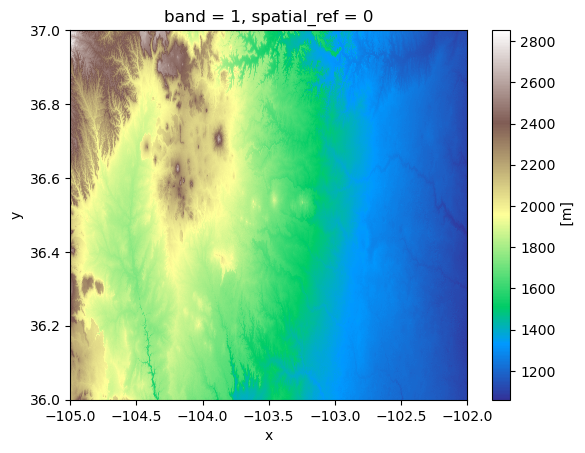

In [ ]:
# Print the DEM for Comanche natl. Grassland
srtm_c_da_list=[]
for srtm_c_path in glob(srtm_c_pattern):
    tile_da = rxr.open_rasterio(srtm_c_path, mask_and_scale=True).squeeze()
    srtm_c_da_list.append(tile_da)
    
srtm_c_da = rxrmerge.merge_arrays(srtm_c_da_list)
srtm_c_da.plot(cmap='terrain')

In [ ]:
# define a pattern which identifies the DEM's belongning to Pawnee National Grasslands

srtm_p_pattern = os.path.join(elevation_dir, 'N40*hgt.zip' and 'N41*hgt.zip')
if not glob(srtm_p_pattern):
    bounds = tuple(pawnee_gdf.total_bounds)
    srtm_results = earthaccess.search_data(
        short_name = "SRTMGL1",
        bounding_box=bounds    
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

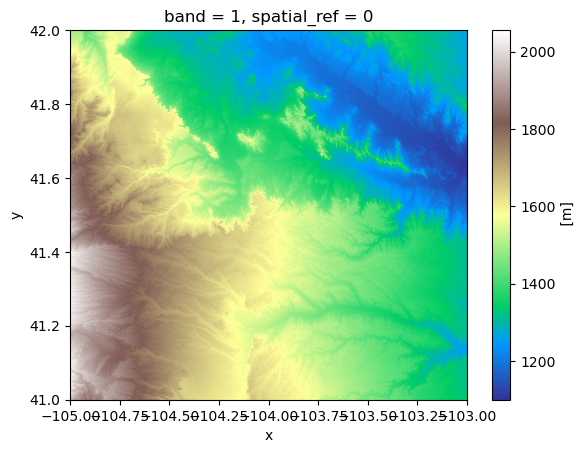

In [11]:
# Print the DEM's for Pawnee Natl Grasslands
srtm_p_da_list=[]
for srtm_p_path in glob(srtm_p_pattern):
    tile_da = rxr.open_rasterio(srtm_p_path, mask_and_scale=True).squeeze()
    srtm_p_da_list.append(tile_da)
    
srtm_p_da = rxrmerge.merge_arrays(srtm_p_da_list)
srtm_p_da.plot(cmap='terrain')

In [ ]:
# Search earthaccess for DEM's corresponding to the bounds of the Comanche_gdf, and download to ~\data\srtm
bounds = tuple(comanche_gdf.total_bounds)
srtm_results_1 = earthaccess.search_data(
    short_name = "SRTMGL1",
    bounding_box=bounds    
)
strm_results_1 = earthaccess.download(srtm_results_1, elevation_dir)

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -103.00027778, 'EastBoundingCoordinate': -101.99972222, 'NorthBoundingCoordinate': 38.00027778, 'SouthBoundingCoordinate': 36.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
 Size(MB): 7.55399
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N37W103.SRTMGL1.hgt/N37W103.SRTMGL1.hgt.zip'],
 Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -103.00027778, 'EastBoundingCoordinate': -101.99972222, 'NorthBoundingCoordinate': 37.00027778, 'SouthBoundingCoordinate': 35.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTim